In [5]:
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
print(tf.__version__)

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import glob
import ntpath
import cv2 # pip install opencv-python

from sklearn.metrics.pairwise import cosine_similarity
import scipy as sc


import io
import bson
from tqdm import tqdm
import matplotlib.pyplot as plt
from imageio import imread
import multiprocessing as mp
from glob import iglob

2.3.1


In [6]:
import os
os.chdir('C:/Users/rishv/OneDrive/Northeastern/SEM3/Algorithmic Digital Marketing/Assignments/Assignment3/Dataset')

In [7]:
bson_file = 'train.bson'
NCORE = 16
max_images = 1000000

input_dir = os.path.abspath(os.path.join(os.getcwd(), ''))
base_dir = os.path.join(os.getcwd())
images_dir = os.path.join(base_dir, 'image')
bson_file = os.path.join(input_dir, bson_file)

print(input_dir)
print(base_dir)
print(images_dir)
print(bson_file)

product_count = 0
category_count = 0
picture_count = 0

C:\Users\rishv\OneDrive\Northeastern\SEM3\Algorithmic Digital Marketing\Assignments\Assignment3\Dataset
C:\Users\rishv\OneDrive\Northeastern\SEM3\Algorithmic Digital Marketing\Assignments\Assignment3\Dataset
C:\Users\rishv\OneDrive\Northeastern\SEM3\Algorithmic Digital Marketing\Assignments\Assignment3\Dataset\image
C:\Users\rishv\OneDrive\Northeastern\SEM3\Algorithmic Digital Marketing\Assignments\Assignment3\Dataset\train.bson


Getting all the images present in the database

Founnd [18069] images


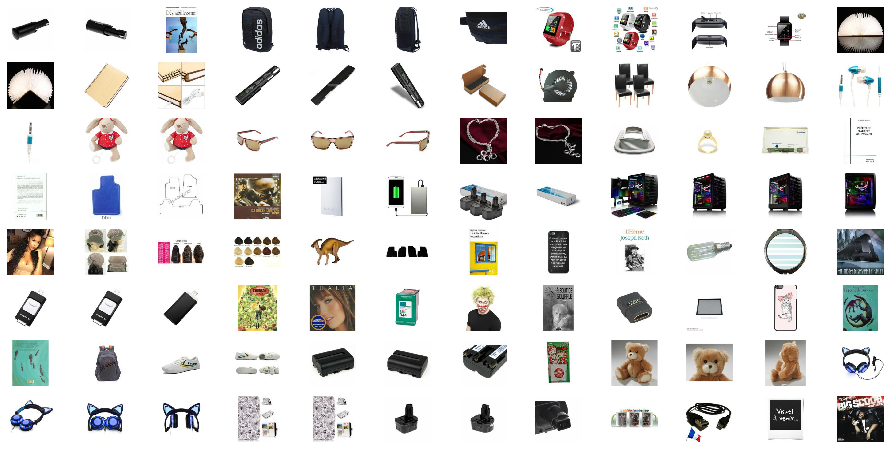

In [8]:
image_paths = glob.glob('C:/Users/rishv/OneDrive/Northeastern/SEM3/Algorithmic Digital Marketing/Assignments/Assignment3/Dataset/image/*.jpg')
print(f'Founnd [{len(image_paths)}] images')

images = {}
for image_path in image_paths:
    image = cv2.imread(image_path, 3) # 3 represent transperency channel 
    b,g,r = cv2.split(image)           # get b, g, r
    image = cv2.merge([r,g,b])         # switch it to r, g, b
    image = cv2.resize(image, (200, 200))
    images[ntpath.basename(image_path)] = image   

images_sample ={}
for key, value in images.items():
    images_sample[key]=value
    if(len(images_sample)==100):
        break

n_col = 12
n_row = int(len(images_sample)/n_col)
f, ax = plt.subplots(n_row, n_col, figsize=(16, 8))
for i in range(n_row):
    for j in range(n_col):
        ax[i, j].imshow(list(images_sample.values())[n_col*i + j])
        ax[i, j].set_axis_off()

Reading the image and setting the content and style for the image

In [9]:
def load_image(image):
  image = plt.imread(image) #reading the image
  img = tf.image.convert_image_dtype(image, tf.float32) #converting image to datatype float
  img = tf.image.resize(img, [400, 400]) #resizing the image
  img = img[tf.newaxis, :] # shape -> (batch_size, h, w, d)
  return img

# content layers describe the image subject
content_layers = ['block5_conv2'] 

# style layers describe the image style
# we exclude the upper level layes to focus on small-size style details
style_layers = [ 
        'block1_conv1',
        'block2_conv1',
        'block3_conv1', 
        #'block4_conv1', 
        #'block5_conv1'
    ] 


In [10]:
def selected_layers_model(layer_names, baseline_model):
  outputs = [baseline_model.get_layer(name).output for name in layer_names]
  model = Model([vgg.input], outputs)
  return model

In [11]:
# style embedding is computed as concatenation of gram matrices of the style layers
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [12]:
class StyleModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleModel, self).__init__()
    self.vgg =  selected_layers_model(style_layers + content_layers, vgg)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    # scale back the pixel values
    inputs = inputs*255.0
    # preprocess them with respect to VGG19 stats
    preprocessed_input = preprocess_input(inputs)
    # pass through the reduced network
    outputs = self.vgg(preprocessed_input)
    # segregate the style and content representations
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    # calculate the gram matrix for each layer
    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    # assign the content representation and gram matrix in
    # a layer by layer fashion in dicts
    content_dict = {content_name:value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content':content_dict, 'style':style_dict}

In [13]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')


In [14]:
def image_to_style(image_tensor):
    extractor = StyleModel(style_layers, content_layers)
    return extractor(image_tensor)['style']

def style_to_vec(style):
    # concatenate gram matrics in a flat vector
    return np.hstack([np.ravel(s) for s in style.values()])

In [15]:
# compute styles
image_style_embeddings = {}
for image_path in tqdm(image_paths): 
    image_tensor = load_image(image_path)
    style = style_to_vec( image_to_style(image_tensor) )
    image_style_embeddings[ntpath.basename(image_path)] = style

100%|██████████████████████████████████████████████████████████████████████████| 18069/18069 [5:32:25<00:00,  1.10s/it]


In [16]:
def search_by_style(reference_image, max_results=10):
    v0 = image_style_embeddings[reference_image]
    distances = {}
    for k,v in image_style_embeddings.items():
        d = sc.spatial.distance.cosine(v0, v)
        distances[k] = d

    sorted_neighbors = sorted(distances.items(), key=lambda x: x[1], reverse=False)
    
    f, ax = plt.subplots(1, max_results, figsize=(16, 8))
    for i, img in enumerate(sorted_neighbors[:max_results]):
        ax[i].imshow(images[img[0]])
        ax[i].set_axis_off()
    
    plt.show()

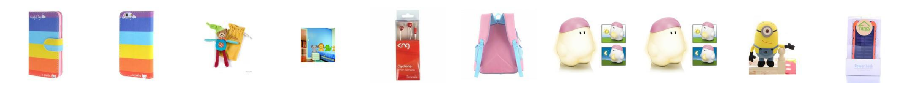

In [17]:
search_by_style('25_0.jpg')

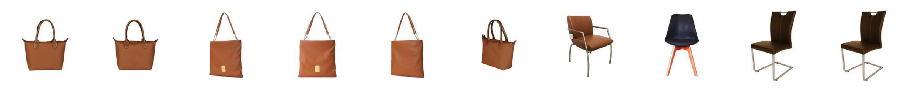

In [18]:
search_by_style('1028_1.jpg')